<a href="https://colab.research.google.com/github/Dhr03/IT314_Lab6/blob/main/Sensitivity_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
covertype = fetch_ucirepo(id=31)

# data (as pandas dataframes)
X = covertype.data.features
y = covertype.data.targets

X = X.to_numpy()
y = y.to_numpy()

# metadata
print(covertype.metadata)

# variable information
print(covertype.variables)

{'uci_id': 31, 'name': 'Covertype', 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype', 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv', 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 581012, 'num_features': 54, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['Cover_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C50K5N', 'creators': ['Jock Blackard'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (30 x 30 meter cell) was determined from

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, adjusted_rand_score, normalized_mutual_info_score

def compute_sensitivities(X, centers):
    # Calculate the distances from each point to each center
    distances = pairwise_distances(X, centers)

    # Get the minimum distance to any center for each point
    min_distances = np.min(distances, axis=1)

    # Sensitivity is proportional to the minimum distance
    sensitivities = min_distances / np.sum(min_distances)

    return sensitivities

def sample_coreset(X, sensitivities, m):
    n = X.shape[0]
    probabilities = sensitivities / np.sum(sensitivities)

    # Ensure that probabilities sum to 1
    probabilities = probabilities / np.sum(probabilities)

    # Sample m points based on the calculated probabilities
    sampled_indices = np.random.choice(n, size=m, p=probabilities, replace=True)

    # Create the coreset and associated weights
    coreset = X[sampled_indices]
    weights = 1 / (m * probabilities[sampled_indices])

    return coreset, weights, sampled_indices


def run_experiment(X, y, k, sizes):
    results = []

    # Run k-means on the full dataset
    full_kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    full_labels = full_kmeans.labels_
    full_cost = full_kmeans.inertia_

    # Compute sensitivities based on initial centers
    initial_kmeans = KMeans(n_clusters=k, max_iter=2*k, random_state=42).fit(X)
    initial_centers = initial_kmeans.cluster_centers_
    sensitivities = compute_sensitivities(X, initial_centers)

    for size in sizes:
        # Sample the coreset
        m = size
        coreset, weights, sampled_indices = sample_coreset(X, sensitivities, m)

        # Run weighted k-means on the coreset
        weighted_kmeans = KMeans(n_clusters=k, random_state=42).fit(coreset, sample_weight=weights)
        coreset_labels = weighted_kmeans.predict(X)
        coreset_cost = weighted_kmeans.inertia_

        # Save the results
        results.append((size, coreset, coreset_labels, sampled_indices, weighted_kmeans, coreset_cost))

    return full_labels, full_kmeans, full_cost, results

# Define the sizes to experiment with
k = 10  # Number of clusters
sizes = [100*k, 200*k, 400*k, 600*k, 800*k, 1000*k]

# Run the experiment
full_labels, full_kmeans, full_cost, results = run_experiment(X, y, k, sizes)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

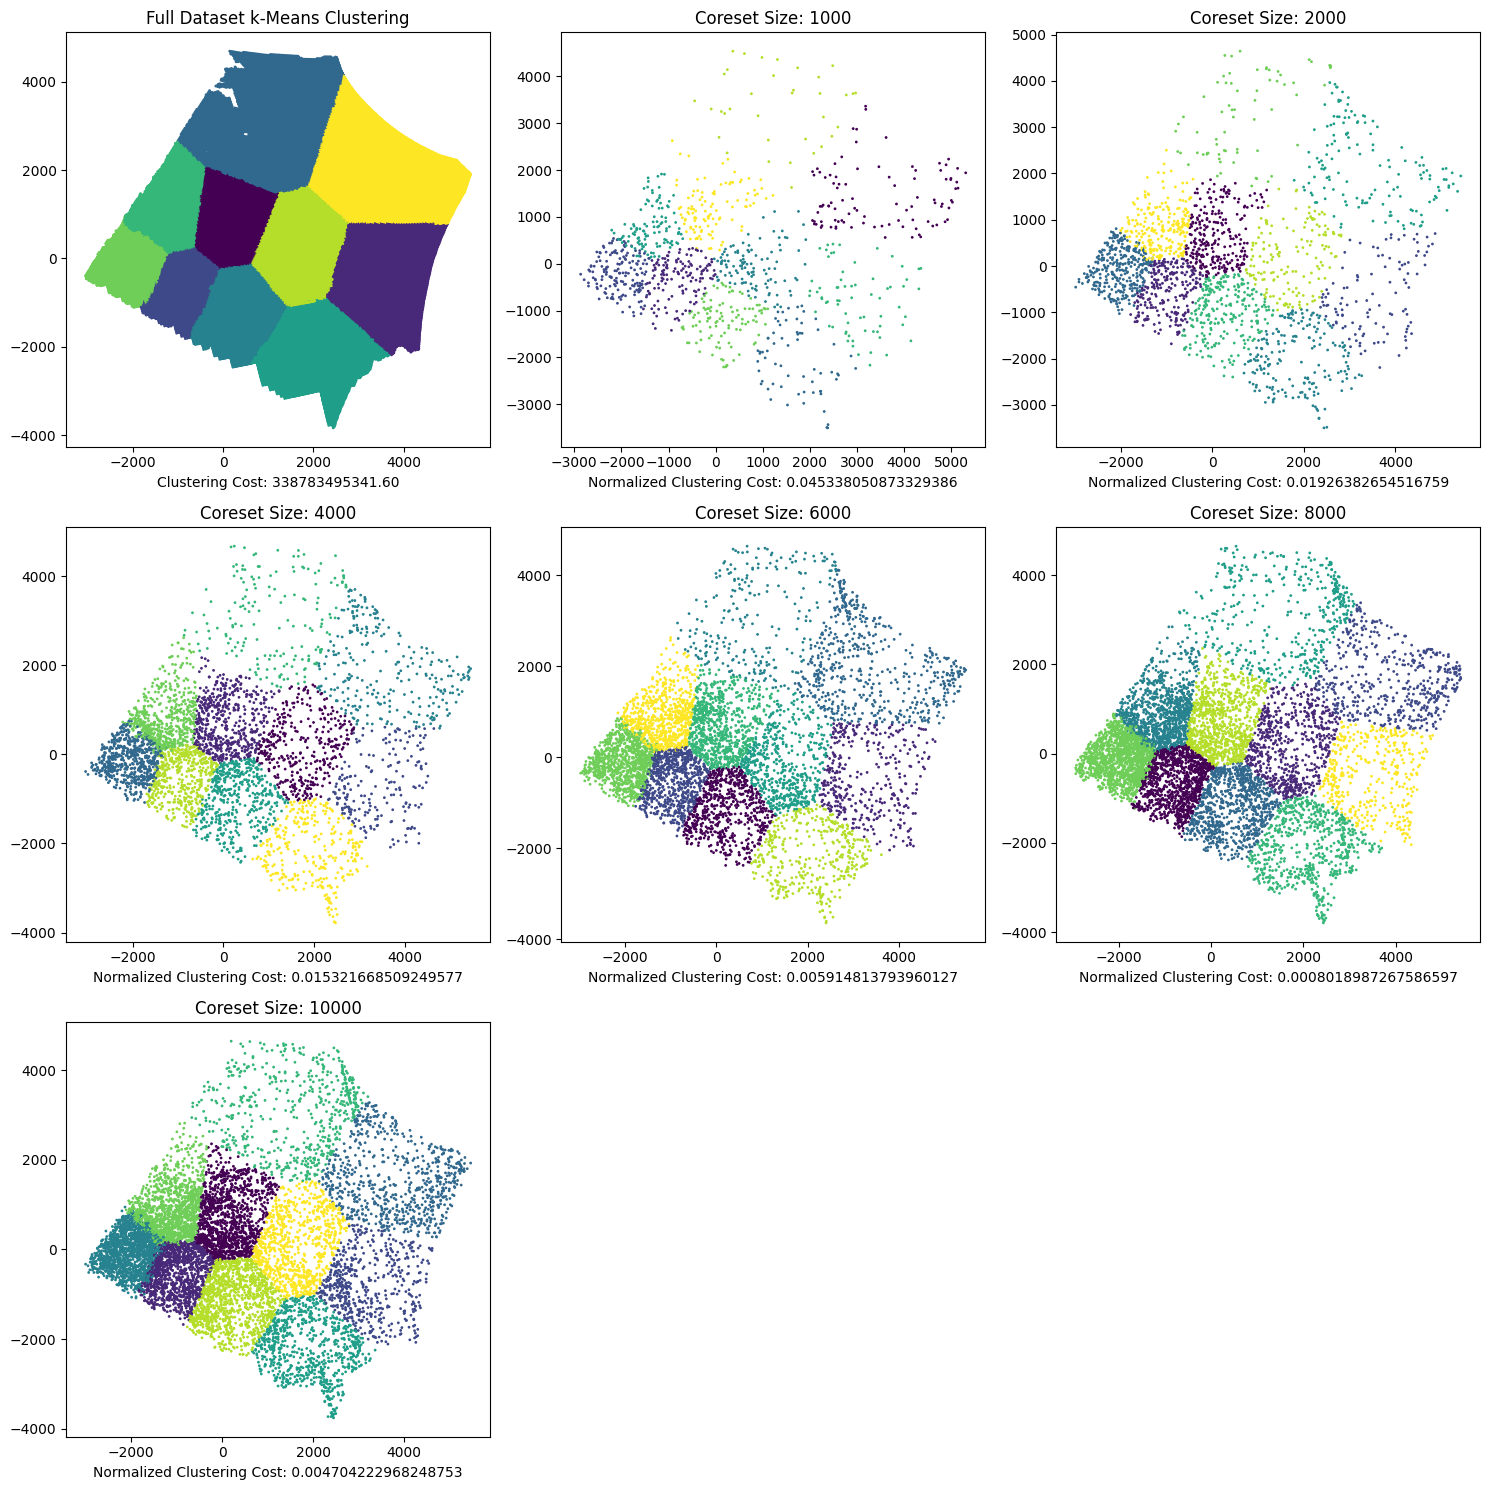

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the full dataset clustering
plt.figure(figsize=(15, 15))
plt.subplot(3, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=full_labels, cmap='viridis', s=1)
plt.title('Full Dataset k-Means Clustering')
plt.xlabel(f'Clustering Cost: {full_cost:.2f}')

# Plot each coreset clustering
for i, (size, coreset, coreset_labels, sampled_indices, weighted_kmeans, coreset_cost) in enumerate(results):
    coreset_pca = pca.transform(coreset)
    normalized_cost = abs(full_cost - coreset_cost) / full_cost
    plt.subplot(3, 3, i + 2)
    plt.scatter(coreset_pca[:, 0], coreset_pca[:, 1], c=coreset_labels[sampled_indices], cmap='viridis', s=1)
    plt.title(f'Coreset Size: {size}')
    plt.xlabel(f'Normalized Clustering Cost: {normalized_cost}')

plt.tight_layout()
plt.show()

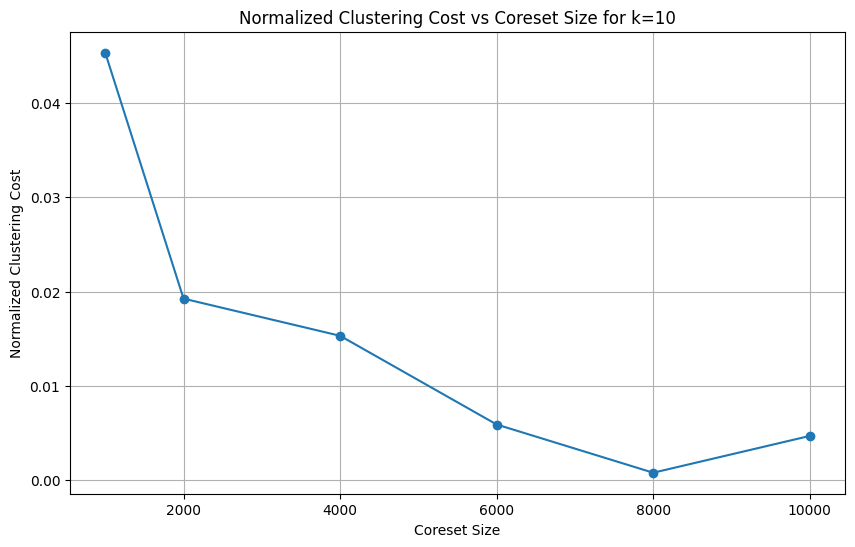

In [ ]:
# Extracting data from the results
sizes = [result[0] for result in results]
coreset_costs = [result[5] for result in results]

# Normalize the coreset costs
normalized_costs = [abs(full_cost - cost) / full_cost for cost in coreset_costs]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sizes, normalized_costs, marker='o')
plt.title(f'Normalized Clustering Cost vs Coreset Size for k={k}')
plt.xlabel('Coreset Size')
plt.ylabel('Normalized Clustering Cost')
plt.grid(True)
plt.show()